<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#UNet-with-efficientnet-model" data-toc-modified-id="UNet-with-efficientnet-model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>UNet with efficientnet model</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [78]:
import wandb
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
import math 
from torch.optim.lr_scheduler import _LRScheduler

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [79]:
batch_size = 8   # Mini-batch size
num_epochs = 60
learning_rate = 0
early_stop = 20

In [80]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [81]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


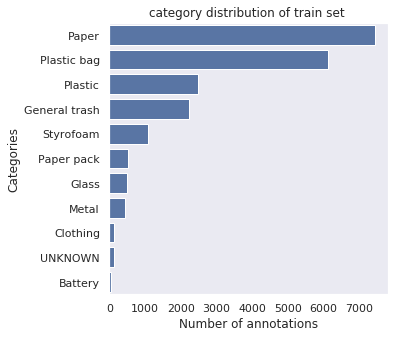

In [82]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [83]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [84]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [85]:
n_class = len(sorted_df)

## 데이터 전처리 함수 정의 (Dataset)

In [86]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)# .astype(np.float32)
        # images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            # print("image_infos['id'] : {}".format(image_infos['id']) )
            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            images = images/ 255.0
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            images = images/ 255.0
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [87]:
# pip install bokeh

In [88]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                              A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p = 0.5),
                              A.HorizontalFlip(p=0.5),
                              A.VerticalFlip(p=0.1),
                              A.Cutout(num_holes=4, max_h_size=20, max_w_size=20 ),
                              A.RandomBrightness(limit=0.3, p = 0.5),
                              A.ShiftScaleRotate(shift_limit=0.05, scale_limit=(-1e-6, 0.1),rotate_limit=30),
                              A.GridDistortion(border_mode=cv2.BORDER_CONSTANT),
                              ToTensorV2()
                              ])
val_transform = A.Compose([ 
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# train_all_path = '../input/data/train_all.json'
# e.g. random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn,
                                           drop_last = True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.05s)
creating index...
index created!
loading annotations into memory...
Done (t=1.68s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [89]:
# # train_loader의 output 결과(image 및 mask) 확인
# for imgs, masks, image_infos in train_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
#     temp_masks = masks
    
#     break

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# print('image shape:', list(temp_images[0].shape))
# print('mask shape: ', list(temp_masks[0].shape))
# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# ax2.imshow(temp_masks[0])
# ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

In [90]:
# # val_loader의 output 결과(image 및 mask) 확인
# for imgs, masks, image_infos in val_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
#     temp_masks = masks
    
#     break

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# print('image shape:', list(temp_images[0].shape))
# print('mask shape: ', list(temp_masks[0].shape))

# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# ax2.imshow(temp_masks[0])
# ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

In [91]:
# # test_loader의 output 결과(image 및 mask) 확인
# for imgs, image_infos in test_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
#     # temp_masks = masks
    
#     break

# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# print('image shape:', list(temp_images[0].shape))

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

## baseline model

### UNet with efficientnet model

In [92]:
num = 4
model_name = 'timm-efficientnet-b'


In [93]:
print(f"{model_name}{num}")

timm-efficientnet-b4


In [94]:
# jupyter command 에서 library download
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

# model 불러오기
# 출력 레이블 수 정의 (classes = 12)

model = smp.DeepLabV3Plus(encoder_name=f'{model_name}{num}', classes=12 , encoder_weights="noisy-student", activation=None)
model = model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /opt/ml/.cache/torch/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

## train, validation, test 함수 정의

In [95]:
from tqdm.notebook import tqdm

In [96]:
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.last_epoch = last_epoch
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [97]:
# type(np.zeros((3,3)))

In [98]:
def train(num_epochs, model, data_loader, val_loader, criterion_1, criterion_2,criterion_rate, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_mIoU = 0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion_rate*criterion_1(outputs, masks) + (1-criterion_rate)*criterion_2(outputs,masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            mIoU , avrg_loss = validation(epoch + 1, model, val_loader,criterion_1, criterion_2,criterion_rate, device)
            
            if mIoU > best_mIoU:
                best_epoch = epoch + 1
                print('Save model in', saved_dir)
                best_mIoU = mIoU
                save_model(model, saved_dir)
            wandb.log({
                "val loss": avrg_loss,
                "val mIoU": mIoU,
                "lr": optimizer.param_groups[0]["lr"],
                "Gap": best_mIoU - mIoU
            })
            scheduler.step()
            if epoch + 1 - best_epoch >= early_stop :
                print("좋은 값이 없다 없어!")
                return 
            print('Best performance at epoch: {} , {}'.format(best_epoch, best_mIoU))
            
    

In [99]:
def validation(epoch, model, data_loader,criterion_1, criterion_2,criterion_rate,  device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images).to(device)       # (batch, channel, height, width)
            masks = torch.stack(masks).long().to(device)   # (batch, channel, height, width)

            outputs = model(images)
            loss = criterion_rate*criterion_1(outputs, masks) + (1-criterion_rate)*criterion_2(outputs,masks)
            total_loss += loss
            cnt += 1    
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()

            mIoUs = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)
            mIoU_list += mIoUs        

        mIoU = np.mean(mIoU_list)
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, mIoU))
        
        print(f'lr={optimizer.param_groups[0]["lr"]}')
        
        
    return mIoU, avrg_loss

## 모델 저장 함수 정의

In [100]:
# 모델 저장 함수 정의
val_every = 1 
t_T_0 = 15
t_eta_max = 0.0004

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name=f'{model_name}{num}_DeeplabV3plus_T1038.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [101]:
file_name=f'{model_name}{num}_DeeplabV3plus_T1038.pt'
output_path = os.path.join(saved_dir, file_name)
output_path

'./saved/timm-efficientnet-b4_DeeplabV3plus_T1038.pt'

In [102]:
# Loss function 정의
criterion_rate = 0.75
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = IoULoss()
# Optimizer 정의




optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0= t_T_0, T_mult=1, eta_max=t_eta_max, T_up=3, gamma=0.3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0)



In [103]:
wandb.init(project="Segmentation")
wandb.run.name = f'{model_name}{num}_Deeplabv3+'


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: openingsound (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.29 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [104]:
#watch -n 0.5 nvidia-smi

In [105]:
train(num_epochs, model, train_loader, val_loader, criterion_1, criterion_2,criterion_rate, optimizer, saved_dir, val_every, device)

Start training..


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60], Step [25/328], Loss: 2.2590
Epoch [1/60], Step [50/328], Loss: 2.2322
Epoch [1/60], Step [75/328], Loss: 2.2279
Epoch [1/60], Step [100/328], Loss: 2.2840
Epoch [1/60], Step [125/328], Loss: 2.2482
Epoch [1/60], Step [150/328], Loss: 2.2373
Epoch [1/60], Step [175/328], Loss: 2.2504
Epoch [1/60], Step [200/328], Loss: 2.2086
Epoch [1/60], Step [225/328], Loss: 2.2325
Epoch [1/60], Step [250/328], Loss: 2.2198
Epoch [1/60], Step [275/328], Loss: 2.2424
Epoch [1/60], Step [300/328], Loss: 2.2105
Epoch [1/60], Step [325/328], Loss: 2.2696


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

## 저장된 model 불러오기 (학습된 이후) 

In [28]:
# model.to('cpu')

In [25]:
# best model 저장된 경로
model_path = f'./saved/{model_name}{num}{model_name}{num}_DeeplabV3plus_T1038.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

In [26]:
# outs.shape


Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {9, 'Plastic bag'}]


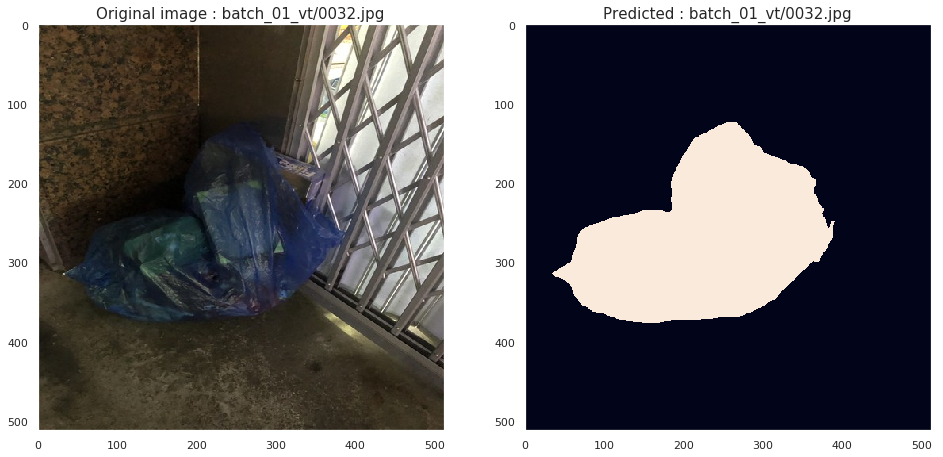

In [27]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
    
    break

size_graph = 8
for idx_x in range(size_graph):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[idx_x]))])
    # Original image
    ax[0].imshow(temp_images[idx_x].permute([1,2,0]))
    ax[0].grid(False)
    ax[0].set_title("Original image : {}".format(image_infos[idx_x]['file_name']), fontsize = 15)

    # Predicted
    ax[1].imshow(oms[idx_x])
    ax[1].grid(False)
    ax[1].set_title("Predicted : {}".format(image_infos[idx_x]['file_name']), fontsize = 15)
    plt.show()

## submission을 위한 test 함수 정의

In [35]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    # all_predictions = [] # 저장할 np
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))

            # for out in outs: # soft voting을 위한 all_predictions에 저장
            #     all_predictions.extend([out.detach().cpu().numpy()])

            # 16*12*256*256
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
            

    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    # all_predictions = np.array(all_predictions) # np로 변환
    # print('all_predictions의 shape : ', all_predictions.shape) # 형태 확인 
    # np.save(f"./submission/{model_name}{num}_test", all_predictions) # 저장 위치, np 

    return file_names, preds_array

## submission.csv 생성

In [36]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in tqdm(zip(file_names, preds)):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/{model_name}{num}_DeeplabV3plus_T1038.csv", index=False)

Start prediction.


0it [00:00, ?it/s]

End prediction.
all_predictions의 shape :  (837, 12, 512, 512)


0it [00:00, ?it/s]

## Reference



In [37]:
submission.to_csv(f"./submission/{model_name}{num}_h_r_v.csv", index=False)